In [1]:
import cv2
import os
import sys
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
SCALING_FACTOR = 0.03460213

In [3]:
# template_fp = "normal images/img_20250110120517618943.png"
template_fp = "images_w_sizes/template.bmp"
# infer_fp = "normal images/img_20250110120847568508.png"
infer_fp = "images_w_sizes/M7.85x30_metal/4.bmp"

## Utils

In [4]:
def get_rbox_dimensions(bpoints, return_corners=False):
    dis = [p[0]**2 + p[1]**2 for p in bpoints]
    tl_idx = np.argsort(dis)[0]
    tr_idx = (tl_idx + 1) % 4
    br_idx = (tl_idx + 2) % 4
    bl_idx = (tl_idx + 3) % 4
    # return width x height of the rotated bbox
    tl_p = bpoints[tl_idx]
    tr_p = bpoints[tr_idx]
    br_p = bpoints[br_idx]
    bl_p = bpoints[bl_idx]
    dimensions = [np.sqrt((tl_p[0]-tr_p[0])**2 + (tl_p[1]-tr_p[1])**2), np.sqrt((tr_p[0]-br_p[0])**2 + (tr_p[1]-br_p[1])**2)]
    if return_corners:
        corners = [tl_p, tr_p, br_p, bl_p]
        return dimensions, corners
    else:
        return dimensions

def point_to_segment_distance(P, A, B):
    """
    Calculate the distance from point P to the line segment AB.

    Parameters:
        P (array-like): The point [px, py].
        A (array-like): The start point of the segment [ax, ay].
        B (array-like): The end point of the segment [bx, by].

    Returns:
        float: The distance from P to the segment AB.
    """
    # Convert inputs to numpy arrays
    P = np.array(P)
    A = np.array(A)
    B = np.array(B)
    
    # Vector AB and AP
    AB = B - A
    AP = P - A
    
    # Dot product of AB with itself
    AB_AB = np.dot(AB, AB)
    
    # Project AP onto AB (scalar t)
    t = np.dot(AP, AB) / AB_AB if AB_AB != 0 else 0  # Handle division by zero
    
    # Clamp t to the segment range [0, 1]
    if t < 0:
        closest = A  # Closest to A
    elif t > 1:
        closest = B  # Closest to B
    else:
        closest = A + t * AB  # Projection point on the segment
    
    # Distance from P to the closest point on the segment
    dist = np.linalg.norm(P - closest)
    
    return dist

def find_peak_points(contoured_points, A, B, reverse=False):
    """
    Find peak points in a set of contoured points relative to a line segment AB.

    Parameters:
        contoured_points (numpy.ndarray): Array of contour points, shape (N, 2).
        A (list or numpy.ndarray): Point A of the line segment [ax, ay].
        B (list or numpy.ndarray): Point B of the line segment [bx, by].

    Returns:
        numpy.ndarray: Array of peak points.
    """
    distances = np.zeros(len(contoured_points))
    peak_indices = np.zeros(len(contoured_points), dtype=bool)

    # Calculate distances
    for i, p in enumerate(contoured_points):
        if reverse:
            distances[i] = -1*point_to_segment_distance(p, A, B)
        else:
            distances[i] = point_to_segment_distance(p, A, B)

    # Identify peaks
    for i in range(10, len(contoured_points) - 10):
        if min(distances[i-9:i+11]) == distances[i]:
            peak_indices[i] = True
            peak_indices[i-9:i+10] = False
            peak_indices[i] = True

    # Extract peak points
    peak_points = []
    for i, is_peak in enumerate(peak_indices):
        if is_peak:
            peak_points.append(contoured_points[i])

    return np.array(peak_points)

In [5]:
def get_best_measured_value(data, method='iqr'):
    """
    Removes outliers and computes the best measured value.
    
    Parameters:
        data (array-like): Array of measured values.
        method (str): Method for outlier detection ('iqr' or 'std').
        
    Returns:
        float: Best measured value after removing outliers (mean of filtered data).
    """
    if method not in ['iqr', 'std']:
        raise ValueError('Invalid method. Choose "iqr" or "std".')

    # Outlier detection and filtering
    if method == 'iqr':
        # IQR-based outlier removal
        Q1 = np.percentile(data, 25)  # First quartile
        Q3 = np.percentile(data, 75)  # Third quartile
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - 1.25 * IQR
        upper_bound = Q3 + 1.25 * IQR
    elif method == 'std':
        # Standard deviation-based outlier removal
        mu = np.mean(data)
        sigma = np.std(data)
        lower_bound = mu - 2 * sigma  # Within 2 standard deviations
        upper_bound = mu + 2 * sigma

    # Filter data within bounds
    filtered_data = [x for x in data if lower_bound <= x <= upper_bound]

    # Compute the best measured value (mean of filtered data)
    best_value = np.mean(filtered_data)

    return best_value

In [6]:
def fit_line(xpos, ypos):
    """
    Fits a line using the linear least-squares method.

    Parameters:
        cs (array-like): x-coordinates (column indices).
        rs (array-like): y-coordinates (row indices).

    Returns:
        np.ndarray: Coefficients [a, b, c] of the line equation ax + by + c = 0.
    """
    # Ensure cs and rs are column vectors
    xpos = np.array(xpos).reshape(-1, 1)
    ypos = np.array(ypos).reshape(-1, 1)

    # Construct U matrix
    U = np.hstack((xpos, ypos, np.ones_like(xpos)))

    # Compute eigenvalues and eigenvectors of U'U
    eig_vals, eig_vecs = np.linalg.eig(U.T @ U)

    # Find the eigenvector corresponding to the smallest eigenvalue
    abc = eig_vecs[:, np.argmin(eig_vals)]

    return abc

In [7]:
def point_to_line(P, abc):
    """
    Projects a point P onto a line defined by the coefficients abc.

    Parameters:
        P (array-like): Coordinates of the point [px, py].
        abc (array-like): Coefficients of the line ax + by + c = 0.

    Returns:
        np.ndarray: Projected point on the line [x_proj, y_proj].
    """
    # Extract coefficients
    a, b, c = abc
    px, py = P

    # Determine line segment points A and B based on orientation
    if abs(b) > abs(a):  # Line is closer to vertical
        A = np.array([(b * 0 + c) / -a, 0])
        B = np.array([(b * 1000 + c) / -a, 1000])
    else:  # Line is closer to horizontal
        A = np.array([0, (a * 0 + c) / -b])
        B = np.array([1000, (a * 1000 + c) / -b])

    # Compute vector AB and AP
    AB = B - A
    AP = np.array(P) - A

    # Dot product of AB with itself
    AB_AB = np.dot(AB, AB)

    # Project AP onto AB (scalar t)
    t = np.dot(AP, AB) / AB_AB

    # Compute the projected point
    projected_point = A + t * AB

    return projected_point


## Get binary images of template & inference images

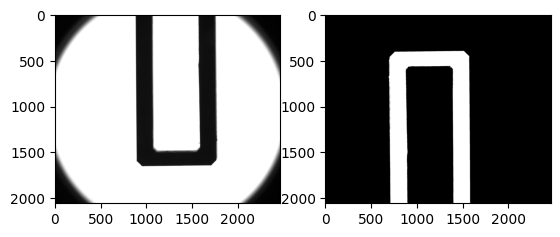

In [8]:
temp_im_g = cv2.imread(template_fp, cv2.IMREAD_GRAYSCALE)
plt.subplot(1, 2, 1)
plt.imshow(temp_im_g, cmap="gray");

_, temp_im_bi = cv2.threshold(temp_im_g, 125, 255, cv2.THRESH_BINARY)
temp_im_bi[:,:600] = 255
temp_im_bi[:, temp_im_bi.shape[1]-600:] = 255
temp_im_bi = cv2.rotate(temp_im_bi, cv2.ROTATE_180)
temp_im_bi = np.uint8(255 - temp_im_bi)
plt.subplot(1, 2, 2)
plt.imshow(temp_im_bi, cmap="gray");
plt.show()

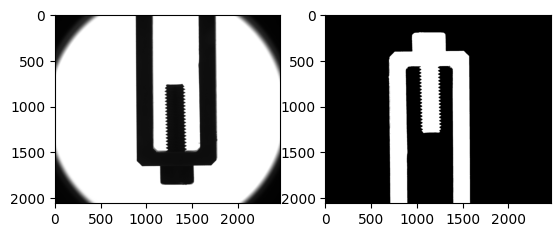

In [9]:
infer_im_g = cv2.imread(infer_fp, cv2.IMREAD_GRAYSCALE)
plt.subplot(1, 2, 1)
plt.imshow(infer_im_g, cmap="gray");

_, infer_im_bi = cv2.threshold(infer_im_g, 125, 255, cv2.THRESH_BINARY)
infer_im_bi[:,:600] = 255
infer_im_bi[:, infer_im_bi.shape[1]-600:] = 255
infer_im_bi = cv2.rotate(infer_im_bi, cv2.ROTATE_180)
infer_im_bi = np.uint8(255 - infer_im_bi)
plt.subplot(1, 2, 2)
plt.imshow(infer_im_bi, cmap="gray");
plt.show()

## Get diff-image that shows only parts of a screw

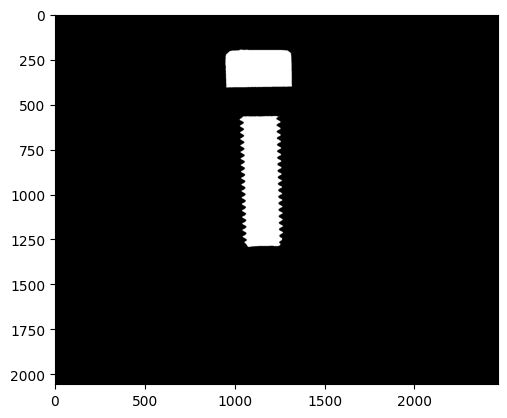

In [10]:
diff_im = cv2.subtract(infer_im_bi, temp_im_bi)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))  # 5x5 rectangular kernel
open_diff_im = cv2.morphologyEx(diff_im, cv2.MORPH_OPEN, kernel)
plt.imshow(open_diff_im, cmap="gray");

In [11]:
# get connected components for head & body parts
head_idx = body_idx = None
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(open_diff_im)
# get first 2 largest connected components excluding background index (0)
interested_indices = 1 + np.argsort(stats[1:, cv2.CC_STAT_AREA])[::-1]  # Skip the background (label 0)
if centroids[interested_indices[0],1] < centroids[interested_indices[1],1]:
    head_idx = interested_indices[0]
    body_idx = interested_indices[1]
else:
    head_idx = interested_indices[1]
    body_idx = interested_indices[0]
head_idx, body_idx

(1, 2)

## Measure head dimensions

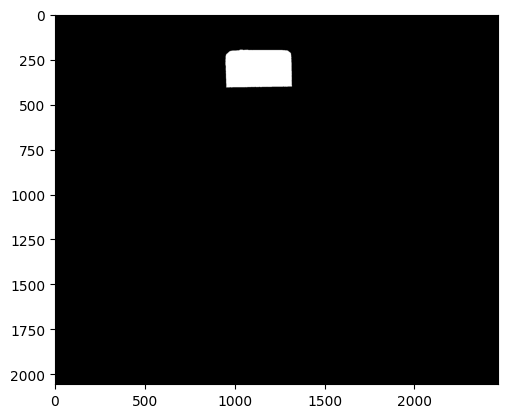

In [12]:
head_blob = (labels == head_idx).astype(np.uint8) * 255
plt.imshow(head_blob, cmap="gray");

Measured dimensions: dk=12.734759129850968 mm, k=7.197991604845985 mm


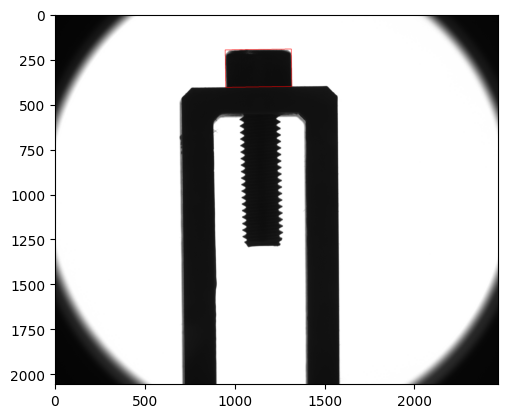

In [13]:
contours, _ = cv2.findContours(head_blob, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Get the rotated rectangle for the largest contour
largest_contour = max(contours, key=cv2.contourArea)
rotated_rect = cv2.minAreaRect(largest_contour)
# Convert the rotated rectangle to box points
box_points = cv2.boxPoints(rotated_rect)
box_points = box_points.astype(int)
w, h = get_rbox_dimensions(box_points)
print(f"Measured dimensions: dk={w*SCALING_FACTOR} mm, k={h*SCALING_FACTOR} mm")

# Draw the rectangle on the image
viz_im = cv2.cvtColor(cv2.rotate(infer_im_g, cv2.ROTATE_180), cv2.COLOR_GRAY2RGB)
cv2.drawContours(viz_im, [box_points], -1, (255, 0, 0), 2)
plt.imshow(viz_im);
cv2.imwrite("viz.png", viz_im[:,:,::-1]);

## Measuring body dimensions

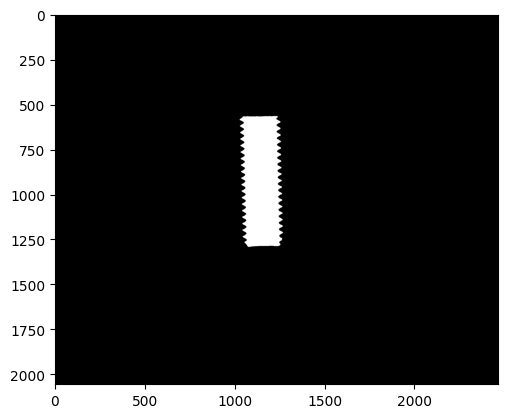

In [14]:
body_blob = (labels == body_idx).astype(np.uint8) * 255
plt.imshow(body_blob, cmap="gray");

### D & L

Measured dimensions: d=7.822836816413982 mm, L=30.146175180241823 mm


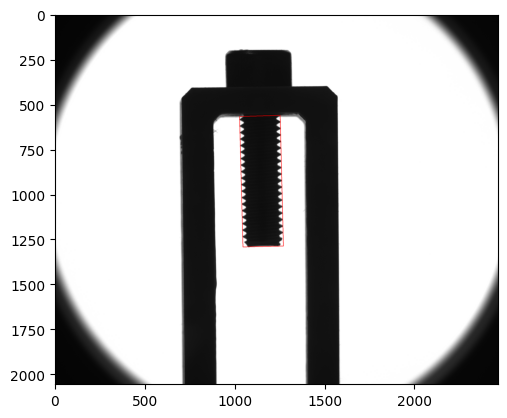

In [15]:
contours, _ = cv2.findContours(body_blob, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# Get the rotated rectangle for the largest contour
largest_contour = max(contours, key=cv2.contourArea)
rotated_rect = cv2.minAreaRect(largest_contour)
# Convert the rotated rectangle to box points
box_points = cv2.boxPoints(rotated_rect)
box_points = box_points.astype(int)
(w, h), corners = get_rbox_dimensions(box_points, return_corners=True)
print(f"Measured dimensions: d={w*SCALING_FACTOR} mm, L={(h+145)*SCALING_FACTOR} mm")

# Draw the rectangle on the image
viz_im = cv2.cvtColor(cv2.rotate(infer_im_g, cv2.ROTATE_180), cv2.COLOR_GRAY2RGB)
cv2.drawContours(viz_im, [box_points], -1, (255, 0, 0), 2)
plt.imshow(viz_im);
cv2.imwrite("viz.png", viz_im[:,:,::-1]);

### Thread pitch

In [16]:
tl_p, tr_p, br_p, bl_p = corners
lpoints, rpoints, tpoints, bpoints = [], [], [], []
for p in largest_contour.squeeze():
    dl = point_to_segment_distance(p, tl_p, bl_p)
    dr = point_to_segment_distance(p, tr_p, br_p)
    dt = point_to_segment_distance(p, tl_p, tr_p)
    db = point_to_segment_distance(p, bl_p, br_p)
    armin = np.argmin([dl, dt, dr, db])
    if armin == 0:
        lpoints.append(p)
    elif armin == 1:
        tpoints.append(p)
    elif armin == 2:
        rpoints.append(p)
    else:
        bpoints.append(p)
        
len(lpoints), len(tpoints), len(rpoints), len(bpoints)

(1016, 221, 987, 213)

In [17]:
sorted_lpoints = sorted(lpoints, key=lambda x: x[1], reverse=True)
sorted_rpoints = sorted(rpoints, key=lambda x: x[1], reverse=True)

In [18]:
for x, y in sorted_lpoints:
    cv2.circle(viz_im, (x, y), radius=1, color=(0, 255, 0), thickness=-1)  # Green filled circles

for x, y in sorted_rpoints:
    cv2.circle(viz_im, (x, y), radius=1, color=(0, 255, 0), thickness=-1)  # Green filled circles
cv2.imwrite("viz.png", viz_im[:,:,::-1]);

In [19]:
peak_lpoints = find_peak_points(sorted_lpoints, tl_p, bl_p)
root_lpoints = find_peak_points(sorted_lpoints, tl_p, bl_p, reverse=True)
peak_rpoints = find_peak_points(sorted_rpoints, tr_p, br_p)
root_rpoints = find_peak_points(sorted_rpoints, tr_p, br_p, reverse=True)
for x, y in peak_lpoints:
    cv2.circle(viz_im, (x, y), radius=5, color=(255, 0, 0), thickness=1)
for x, y in peak_rpoints:
    cv2.circle(viz_im, (x, y), radius=5, color=(255, 0, 0), thickness=1)
for x, y in root_lpoints:
    cv2.circle(viz_im, (x, y), radius=5, color=(0, 0, 255), thickness=1)
for x, y in root_rpoints:
    cv2.circle(viz_im, (x, y), radius=5, color=(0, 0, 255), thickness=1)
    
cv2.imwrite("viz.png", viz_im[:,:,::-1]);

In [20]:
p_measures = [] 
for i in range(len(peak_lpoints)-1):
    dis = np.linalg.norm(np.array(peak_lpoints[i]) - np.array(peak_lpoints[i+1]))
    p_measures.append(dis)
for i in range(len(peak_rpoints)-1):
    dis = np.linalg.norm(np.array(peak_rpoints[i]) - np.array(peak_rpoints[i+1]))
    p_measures.append(dis)

p_final = get_best_measured_value(p_measures, "iqr")
print(f"Measured thead pitch (P): {p_final*SCALING_FACTOR} mm")

Measured thead pitch (P): 1.2545394158188135 mm


### Thread depth

In [21]:
# form a line which goes through all roots of the left side
root_lpoints_np = np.array(root_lpoints)
root_line_l = fit_line(root_lpoints_np[:,0], root_lpoints_np[:,1])
print(root_line_l)
# form a line which goes through all roots of the right side
root_rpoints_np = np.array(root_rpoints)
root_line_r = fit_line(root_rpoints_np[:,0], root_rpoints_np[:,1])
print(root_line_r)

[-9.65975118e-04  2.42092245e-05  9.99999533e-01]
[-8.22619642e-04  2.02727420e-05  9.99999661e-01]


In [22]:
# visulization
# line: ax + by + c = 0
y1 = int(root_lpoints[0][1])
x1 = int((root_line_l[1]*y1 + root_line_l[2])/(-root_line_l[0]))
y2 = int(root_lpoints[-1][1])
x2 = int((root_line_l[1]*y2 + root_line_l[2])/(-root_line_l[0]))
cv2.line(viz_im, (x1,y1), (x2,y2), (255,0,0), 1)

y3 = int(root_rpoints[0][1])
x3 = int((root_line_r[1]*y3 + root_line_r[2])/(-root_line_r[0]))
y4 = int(root_rpoints[-1][1])
x4 = int((root_line_r[1]*y2 + root_line_r[2])/(-root_line_r[0]))
cv2.line(viz_im, (x3,y3), (x4,y4), (255,0,0), 1)

cv2.imwrite("viz.png", viz_im[:,:,::-1]);

In [23]:
tp_measures = []
for i in range(1,len(peak_lpoints)-1):
    ppoint = point_to_line(peak_lpoints[i], root_line_l)
    dis = np.linalg.norm(np.array(peak_lpoints[i]) - np.array(ppoint))
    tp_measures.append(dis)
for i in range(1,len(peak_rpoints)-1):
    ppoint = point_to_line(peak_rpoints[i], root_line_r)
    dis = np.linalg.norm(np.array(peak_rpoints[i]) - np.array(ppoint))
    tp_measures.append(dis)

tp_final = get_best_measured_value(tp_measures, "iqr")
print(f"Measured Thread depth (TP): {tp_final*SCALING_FACTOR} mm")

Measured Thread depth (TP): 0.7566643791537154 mm
